In [1]:
import numpy as np
import os

datapath = 'data/mnist.npz'
if not os.path.exists(datapath):
    print('start download mnist dataset...')
    wget.download('https://s3.amazonaws.com/img-datasets/mnist.npz', out=datapath)
f = np.load(datapath)
x_train, y_train = f['x_train'], f['y_train']
x_test, y_test = f['x_test'], f['y_test']
f.close()

# normalization
x_train = x_train/255
x_test = x_test/255

# reshape to add channel dimension. Uses channel first format
x_train = x_train.reshape(-1, 1, x_train.shape[1], x_train.shape[2])
x_test = x_test.reshape(-1, 1, x_test.shape[1], x_test.shape[2])
print ("input shape:", x_train.shape)
print ("output shape:", y_test.shape)

# reserve 20% training data for validation
x_val = x_train[: int(x_train.shape[0]*0.2)]
y_val = y_train[: x_val.shape[0]]
x_train = x_train[x_val.shape[0]:]
y_train = y_train[y_val.shape[0]:]

print ("training samples :",x_train.shape[0])
print ("validation samples :",x_val.shape[0])
print ("test samples :",x_test.shape[0])


input shape: (60000, 1, 28, 28)
output shape: (10000,)
training samples : 48000
validation samples : 12000
test samples : 10000


In [2]:
# from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
from nn.layers import *
from nn.model import Model
import numpy as np

# set up model
model = Model(x_train.shape[1:])
model.add(Convolution(
    {
        'kernel_h': 3,
        'kernel_w': 3,
        'pad': 1,
        'stride': 1,
        'in_channel': 1,
        'out_channel': 3
    }, 
    name='conv1'
))
model.add(ReLU(name='relu1'))
model.add(Pooling(
    {
        'pool_type': 'max',
        'pool_height': 2,
        'pool_width': 2,
        'stride': 2,
        'pad': 0
    }, 
    name='pooling1'
))

model.add(Flatten(name='flatten'))
model.add(FCLayer(16, name='dense1'))
model.add(ReLU(name='relu3'))
model.add(Dropout(rate=0.5))

model.add(FCLayer(10, name='dense2'))
model.add(SoftmaxCrossEntropy())


adam = Adam(lr=0.001, decay=0,  sheduler_func = None, bias_correction=True)
# l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model.compile(optimizer=adam, regularization=None)
model.summary()
train_stats, val_stats = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=30, 
    epochs=10, 
    verbose=1, 
    callbacks=None, 
    validation_split=0.0, 
    validation_data=(x_val, y_val), 
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0, 
    steps_per_epoch=None, 
    validation_steps=None, 
    validation_freq=1, 
    max_queue_size=None, 
    workers=1, 
    use_multiprocessing=False
)


====== MODEL SUMMARY ======
input shape: (None, 1, 28, 28)
conv1 output shape: (None, 3, 28, 28)
relu1 output shape: (None, 3, 28, 28)
pooling1 output shape: (None, 3, 14, 14)
flatten output shape: (None, 588)
dense1 output shape: (None, 16)
relu3 output shape: (None, 16)
dropout output shape: (None, 16)
dense2 output shape: (None, 10)
softmax output shape: (None, 10)
==>Epoch: 1 / 10  Steps: 1600
train_loss: 1.1644836524884854  train_acc: 0.5737916666666667  val_loss: 0.4930981540590358  val_acc: 0.8769166666666667
==>Epoch: 2 / 10  Steps: 1600
train_loss: 0.9137937127789872  train_acc: 0.6724166666666667  val_loss: 0.41699972693628085  val_acc: 0.8943333333333333
==>Epoch: 3 / 10  Steps: 1600
train_loss: 0.8852947693066459  train_acc: 0.6868958333333334  val_loss: 0.40774751309223856  val_acc: 0.8979166666666667
==>Epoch: 4 / 10  Steps: 1600
train_loss: 0.8593018786590807  train_acc: 0.696  val_loss: 0.3967356391268691  val_acc: 0.9000833333333333
==>Epoch: 5 / 10  Steps: 1600
train_

test accuracy = 0.9104


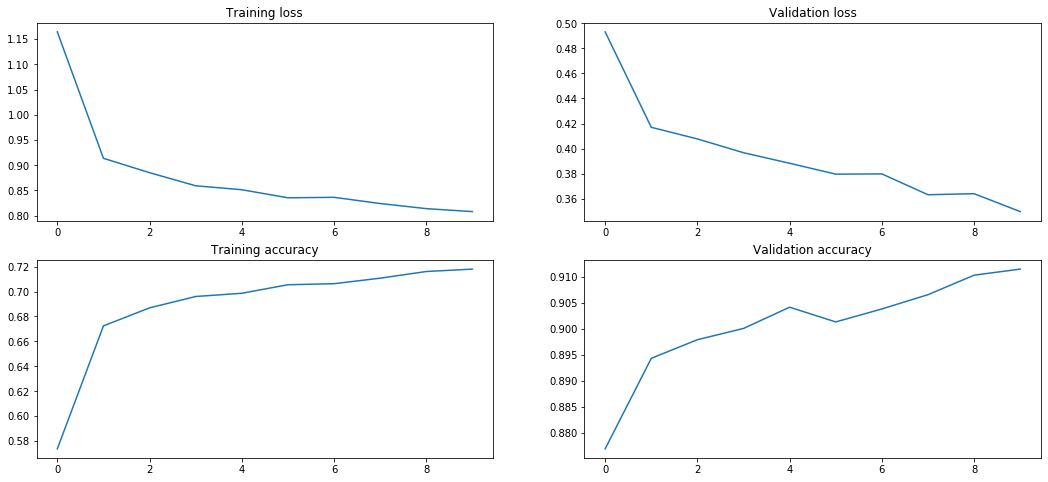

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_stats[:,0], train_stats[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_stats[:,0], train_stats[:,2])
plt.subplot(2, 2, 2)
plt.title('Validation loss')
plt.plot(val_stats[:,0], val_stats[:, 1])
plt.subplot(2, 2, 4)
plt.title('Validation accuracy')
plt.plot(val_stats[:, 0], val_stats[:,2])

# # test against full testdata
_, probs = model.predict(x_test)
accuracy = np.sum(np.argmax(probs, axis=-1) == y_test) / y_test.shape[0]
print("test accuracy =", accuracy)


Four examples of test images:
decoded results: [8 4 1 1]


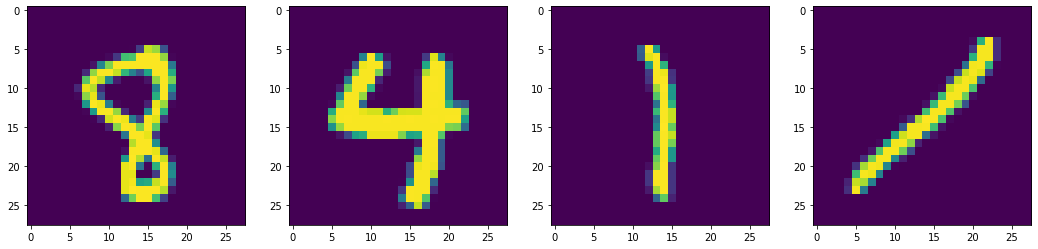

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

idx = np.random.randint(x_test.shape[0], size=4)
print('\nFour examples of test images:')
img = x_test[idx][:,0,:,:]
plt.figure(1, figsize=(18, 18))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.subplot(1, 4, 2)
plt.imshow(img[1])
plt.subplot(1, 4, 3)
plt.imshow(img[2])
plt.subplot(1, 4, 4)
plt.imshow(img[3])

loss, probs = model.predict(x_test[idx])
print ('decoded results:', np.argmax(probs, axis=1))